In [2]:
#from pychastic.sde_solver import SDESolver
#from pychastic.sde_solver import VectorSDESolver
import pychastic
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm


# Testing Vector Euler

In [7]:
problem = pychastic.sde_problem.VectorSDEProblem(
  lambda x: jnp.array([1/(2*x[0]),0]),       # [1/2r,0]
  lambda x: jnp.array([
    [jnp.cos(x[1]),jnp.sin(x[1])],           # cos \phi,      sin \phi
    [-jnp.sin(x[1])/x[0],jnp.cos(x[1])/x[0]] # -sin \phi / r, cos \phi / r
  ]),
  dimension = 2,
  noiseterms= 2,
  x0 = jnp.array([1.0,0.0]), # r=1.0, \phi=0.0
  tmax=1.0
)


solvers = [
  pychastic.sde_solver.VectorSDESolver(scheme='euler'),
  pychastic.sde_solver.VectorSDESolver(scheme='milstein'),
]

dts = [2**-5, 2**-6, 2**-7, 2**-8]
n_rows = 2
n_wieners_per_cell = 2

results = np.zeros((len(solvers), len(dts), n_rows, n_wieners_per_cell), dtype=dict)  # solver x dt x wiener

for n_solver, solver in enumerate(solvers):
  for n_dt, dt in tqdm(enumerate(dts)):
    solver.dt = dt
    #for n_row in tqdm(range(n_rows)):
    for n_row in range(n_rows):
      #solutions = solver.solve_many(problem,n_trajectories=n_wieners_per_cell)
      solutions = np.array([solver.solve(problem) for it in range(n_wieners_per_cell)])
      print(solutions[0].shape)
      results[n_solver, n_dt, n_row] = solutions

0it [00:00, ?it/s]ipykernel_launcher:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
0it [00:00, ?it/s]

(2, 3)


ValueError: could not broadcast input array from shape (2,2,3) into shape (2)

In [219]:
s = results.shape
results_flat = results.flatten()
def to_cartesian(x):
  return x[0]*jnp.array([jnp.cos(x[1]),jnp.sin(x[1])])
def f(sol):
  x = to_cartesian(sol['solution_values'][-1])
  x_exact = sol['wiener_values'][-1] + jnp.array([1,0])
  e = jnp.sqrt(jnp.sum((x - x_exact)**2)) # L2 norm error
  return e
errors = np.array([f(x) for x in results_flat]).reshape(s)
errors.shape

(2, 4, 20, 20)

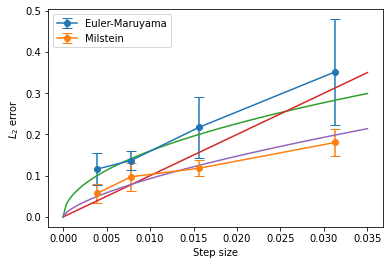

In [222]:
table_euler = errors[0].mean(axis=-1).T
mu_euler = table_euler.mean(axis=0)
sd_euler = table_euler.std(axis=0)/np.sqrt(n_wieners_per_cell)

table_milstein = errors[1].mean(axis=-1).T
mu_milstein = table_milstein.mean(axis=0)
sd_milstein = table_milstein.std(axis=0)/np.sqrt(n_wieners_per_cell)

lsp = jnp.linspace(0.0,0.035,100)
mu_pred_euler = [1.6*x**(1/2) for x in lsp]
mu_pred_milstein = [10*x for x in lsp]
mu_pred_milstein_wolfram = [2*x**(2/3) for x in lsp]
plt.errorbar(dts, mu_euler, 2*sd_euler, capsize=5, marker='o', label='Euler-Maruyama')
plt.errorbar(dts, mu_milstein, 2*sd_milstein, capsize=5, marker='o', label='Milstein')
plt.xlabel('Step size')
plt.ylabel('$L_2$ error')
plt.plot(lsp, mu_pred_euler)
plt.plot(lsp, mu_pred_milstein)
plt.plot(lsp, mu_pred_milstein_wolfram)
plt.legend()